In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import repeat
from collections import defaultdict
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


# to disable ssl certificate check...
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
work_path = '/cluster/raid/home/f80878961/agripol/'

pathogen_data_fn = '{}Agripol all pathogen data beta Actin complet to use for stats.xlsx'.format(work_path)

coleval_data_fn = '{}agripol_coleval_clean_20231228 unprotect_corrected.xlsx'.format(work_path)

# Parse ColEval table

In [3]:
dfs = pd.read_excel(coleval_data_fn, sheet_name=None, engine='openpyxl')
dfs.keys()

dict_keys(['coleval_2018', 'coleval_2019', 'coleval_2020', 'coleval_2021', 'coleval_2022', 'coleval_2023', 'codeboook'])

In [4]:
coleval_df = pd.concat(
    [dfs['coleval_2018'].iloc[:, :22],
    dfs['coleval_2019'].iloc[:, :22].rename(columns={'anneeRuche2': 'anneeRuche'}),
    dfs['coleval_2020'].iloc[:, :22].rename(columns={'anneeRuche3': 'anneeRuche'}),
    dfs['coleval_2021'].iloc[:, :22].rename(columns={'anneeRuche4': 'anneeRuche'}),
    dfs['coleval_2022'].iloc[:, :22].rename(columns={'anneeRuche5': 'anneeRuche'}),
    dfs['coleval_2023'].iloc[:, :22].rename(columns={'anneeRuche4': 'anneeRuche'})]
)

In [5]:
coleval_df

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
0,v1R01C012018,R01,2018,C01,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,440.0,0.0,9504.0,275.0,9075.0,190.0,21.546,220.0,24.948
1,v1R01C022018,R01,2018,C02,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,175.0,0.0,3780.0,105.0,3465.0,110.0,12.474,170.0,19.278
2,v1R01C032018,R01,2018,C03,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,515.0,0.0,11124.0,490.0,16170.0,300.0,34.020,215.0,24.381
3,v1R01C042018,R01,2018,C04,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,220.0,0.0,4752.0,255.0,8415.0,240.0,27.216,120.0,13.608
4,v1R01C052018,R01,2018,C05,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,680.0,0.0,14688.0,485.0,16005.0,570.0,64.638,295.0,33.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,v1R30C06_2023,R30,2023,C06,2021.0,NaT,v4,NaN,Cédric Reymond,D,D,NaN,colonie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,v1R30C07_2023,R30,2023,C07,2021.0,NaT,v4,NaN,Cédric Reymond,D,NaN,NaN,colonie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,v1R30C08_2023,R30,2023,C08,2021.0,NaT,v4,NaN,Cédric Reymond,D,NaN,NaN,colonie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,v1R30C09_2023,R30,2023,C09,2018.0,NaT,v4,NaN,Cédric Reymond,D,D,NaN,colonie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Parse pathogen data

In [6]:
dfs = pd.read_excel(pathogen_data_fn, sheet_name=None, engine='openpyxl')
dfs.keys()

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/

dict_keys(['Runs 2018', 'Runs 2019', 'Runs 2020', 'Runs 2021', 'Runs 2022', 'missing bactin'])

In [7]:
def clean_df(df, pathogens, apis_col, βActin_col):
    '''
    custom function to clean agripol pathogen excel file
    '''
    p2cols = defaultdict(list)
    columns = []
    curr_pathogen = None
    for c in df.columns:
        if c in pathogens:
            curr_pathogen = c
        if curr_pathogen and c not in {apis_col, βActin_col}:
            p2cols[curr_pathogen].append(c)
            columns.append(c)
    
    new_cols = []
    for p, cols in p2cols.items():
        assert len(cols) >1 & len(cols) <4
        
        # ct and detected?
        if len(cols) == 2:
            new_cols.extend(['{} Ct value'.format(p), '{} Detected'.format(p)])
        
        # ct, delta ct , and detected
        else:
            new_cols.extend(['{} Ct value'.format(p), '{} delta Ct'.format(p), '{} Detected'.format(p)])
    
    assert len(columns) == len(new_cols)

    return df, columns, new_cols

2018

get pathogen names from this first table

In [8]:
year = 2018
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'βActin RT'

In [9]:
df = dfs['Runs {}'.format(year)]
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)',
       'Melissococcus plutonius', 'Unnamed: 11', 'Paenibacillus larvae',
       'Unnamed: 13', 'Ascosphera', 'Unnamed: 15', 'Nosema ceranae',
       'Unnamed: 17', 'Nosema apis', 'Unnamed: 19', 'βActin RT', 'DWV A',
       'Unnamed: 22', 'DWV B', 'Unnamed: 24', 'Unnamed: 25', 'DWV C',
       'Unnamed: 27', 'Unnamed: 28', 'SBV', 'Unnamed: 30', 'Unnamed: 31',
       'BCQV', 'Unnamed: 33', 'Unnamed: 34', 'ABPV', 'Unnamed: 36',
       'Unnamed: 37', 'KBV', 'Unnamed: 39', 'Unnamed: 40', 'IAPV',
       'Unnamed: 42', 'Unnamed: 43'],
      dtype='object')

In [10]:
pathogens = []
for c in df:
    if not c.startswith('Unnamed') and c not in {apis_col, βActin_col}:
        pathogens.append(c)

assert len(pathogens) == 13
pathogens

['Melissococcus plutonius',
 'Paenibacillus larvae',
 'Ascosphera',
 'Nosema ceranae',
 'Nosema apis',
 'DWV A',
 'DWV B',
 'DWV C',
 'SBV',
 'BCQV',
 'ABPV',
 'KBV',
 'IAPV']

In [11]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [12]:
# skip first row and rows without qPCR values
df_2018 = df.loc[1:788, other_columns + columns]
df_2018.columns = other_columns_new_names + new_cols

# filter rows without Rucher, Colonie, etc. even if there are PCR values ?

2019

In [13]:
year = 2019
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'β-Actin RT run no 200824 1+2 et 2008243'

df = dfs['Runs {}'.format(year)]
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [14]:
# skip first row and rows without qPCR values
df_2019 = df.loc[1:1076, other_columns + columns]
df_2019.columns = other_columns_new_names + new_cols

2020

- no IAPV

In [15]:
year = 2020
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [16]:
df = dfs['Runs {}'.format(year)]

In [17]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'}).drop('Unnamed: 46', axis=1)

In [18]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [19]:
# skip first row and rows without qPCR values
df_2020 = df.loc[1:934, other_columns + columns]
df_2020.columns = other_columns_new_names + new_cols

2021

In [20]:
year = 2021
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [21]:
df = dfs['Runs {}'.format(year)]

In [22]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'})

In [23]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [24]:
# skip first row and rows without qPCR values
df_2021 = df.loc[1:951, other_columns + columns]
df_2021.columns = other_columns_new_names + new_cols

2022

- no ABPV, KBV, IAPV, which are strains of KIABPV --> assumption KIABPV = IAPV as no ABPV and KBV in 2018-2021

In [25]:
year = 2022
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [26]:
df = dfs['Runs {}'.format(year)]

In [27]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema Apis':'Nosema apis', 'KIABPV' : 'ABPV'}).drop('Ct values for ABPV, KBV IAPV not available this year', axis=1)

In [28]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [29]:
# skip first row and rows without qPCR values
df_2022 = df.loc[1:957, other_columns + columns]
df_2022.columns = other_columns_new_names + new_cols

Merge datasets

In [30]:
print(df_2018.shape)
print(df_2019.shape)
print(df_2020.shape)
print(df_2021.shape)
print(df_2022.shape)

(788, 38)
(1076, 39)
(934, 36)
(951, 39)
(957, 29)


In [31]:
print(set(df_2019.columns).difference(df_2018))
print(set(df_2019.columns).difference(df_2020))
print(set(df_2019.columns).difference(df_2021))
print(set(df_2019.columns).difference(df_2022))

{'DWV A delta Ct'}
{'IAPV delta Ct', 'IAPV Ct value', 'IAPV Detected'}
set()
{'IAPV delta Ct', 'KBV Ct value', 'SBV delta Ct', 'SBV Ct value', 'ABPV delta Ct', 'SBV Detected', 'KBV delta Ct', 'KBV Detected', 'IAPV Detected', 'IAPV Ct value'}


In [32]:
df_all = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [33]:
df_all.shape

(4706, 39)

In [34]:
pathogen_nr = [0] * len(df_all)

df_prev_rows = [list] * len(df_all)
# df_abun_rows = [] * len(df_2019)

for i in range(len(df_all)):
    row = [0] * len(pathogens)
    for j, p in enumerate(pathogens):
        if df_all.iloc[i, df_all.columns.get_loc('{} Detected'.format(p))] == '+':
            pathogen_nr[i] += 1
            row[j] = 1
    df_prev_rows[i] = row

In [35]:
df_prev = pd.DataFrame(df_prev_rows, columns=pathogens)

In [36]:
df_prev

,Melissococcus plutonius,Paenibacillus larvae,Ascosphera,Nosema ceranae,Nosema apis,DWV A,DWV B,DWV C,SBV,BCQV,ABPV,KBV,IAPV
0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,0,0,0,1,0,0,0,0,0,0,0,0,0
4702,0,0,0,1,0,0,0,0,0,0,0,0,0
4703,0,0,0,1,0,0,0,0,0,0,0,0,0
4704,0,0,0,1,0,0,0,0,0,0,0,0,0


# Cluster samples by presence absence of pathogens

In [37]:
sum(df_prev['KBV'])
sum(df_prev['IAPV'])

0

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


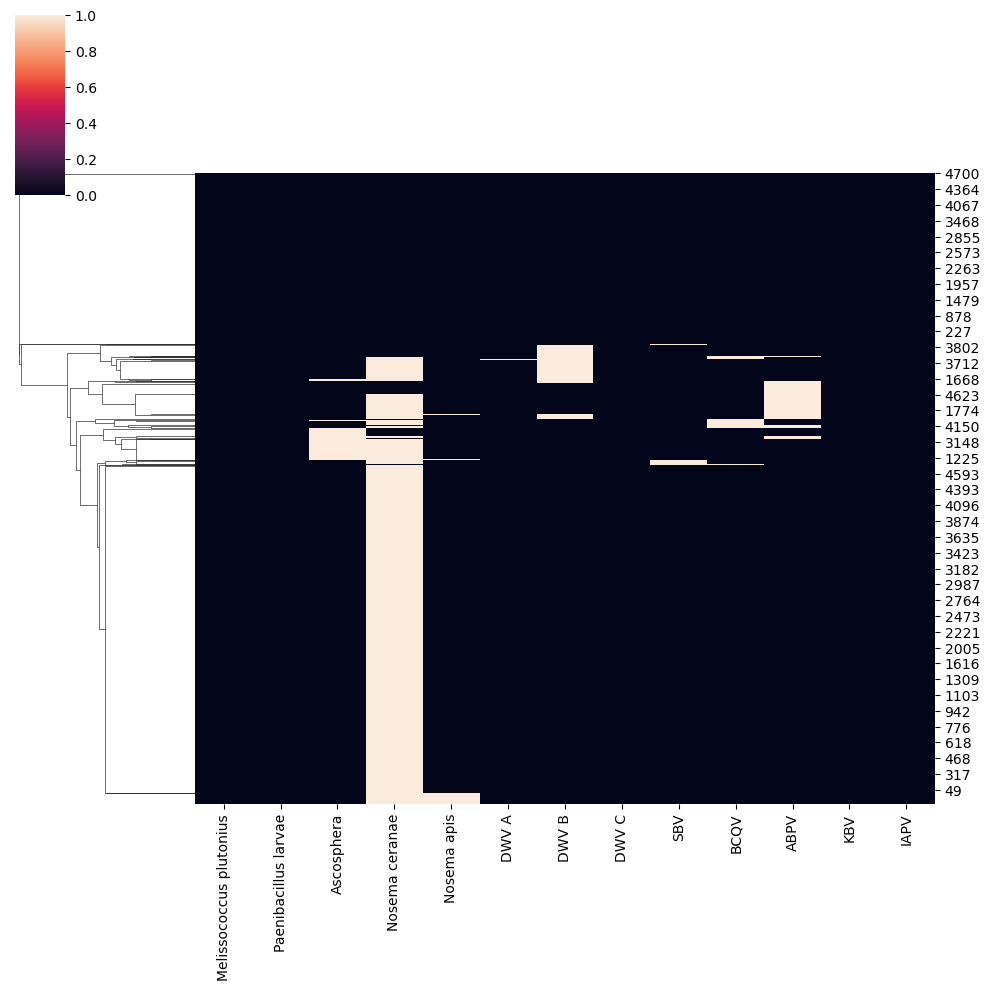

In [38]:
cg = sns.clustermap(df_prev, metric='jaccard', col_cluster=False)

In [39]:
df_prev.sum(axis=0)

Melissococcus plutonius       1
Paenibacillus larvae          4
Ascosphera                  265
Nosema ceranae             3155
Nosema apis                  87
DWV A                        15
DWV B                       325
DWV C                         0
SBV                          46
BCQV                        102
ABPV                        341
KBV                           0
IAPV                          0
dtype: int64

/tmp/ipykernel_172259/2600048935.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


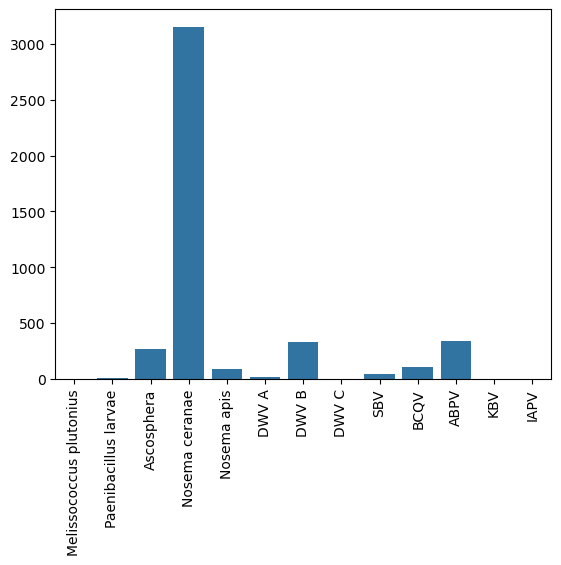

In [40]:
ax = sns.barplot(df_prev.sum(axis=0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [38]:
min_patho_nr = 3
df_prev_filtered = df_prev[df_prev.sum(axis=1) >= min_patho_nr].drop(columns=df_prev.columns[df_prev.sum(axis=0) == 0])

In [39]:
df_prev_filtered.shape

(131, 10)

/tmp/ipykernel_3075160/2880208192.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


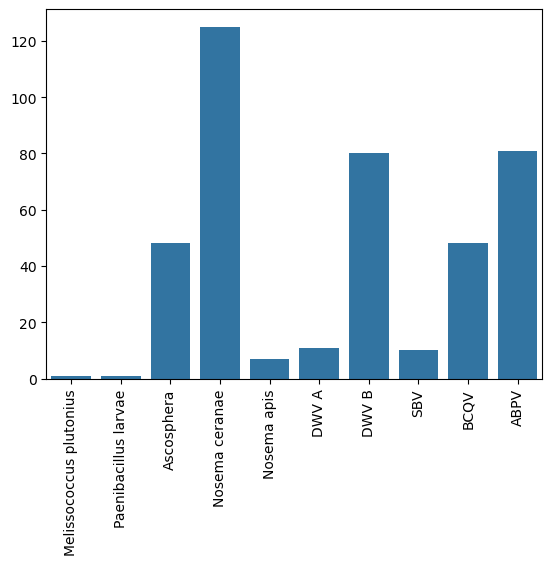

In [40]:
ax = sns.barplot(df_prev_filtered.sum(axis=0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

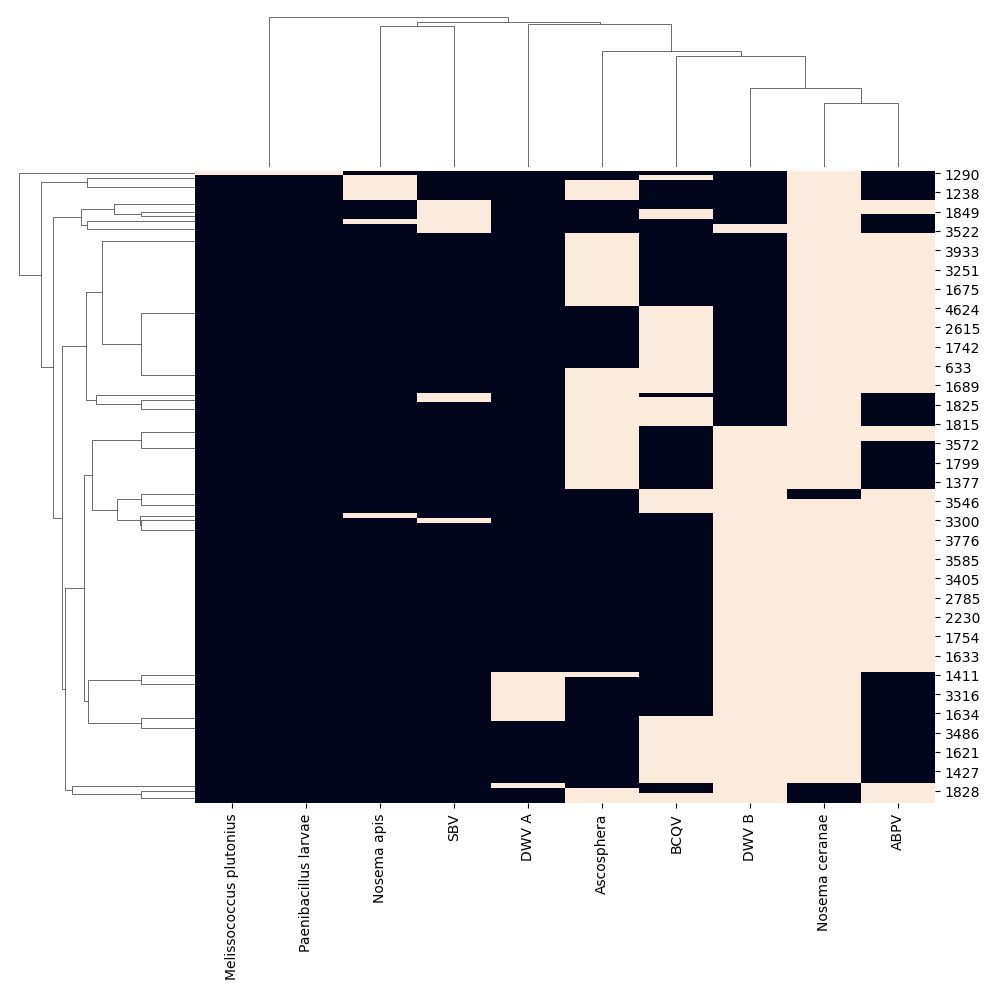

In [41]:
cg = sns.clustermap(df_prev_filtered, metric='jaccard', col_cluster=True)
cg.cax.set_visible(False)



In [42]:
clustered_rows = np.array(df_prev_filtered.index[cg.dendrogram_row.reordered_ind])

In [43]:
# new index clustered
new_idx_clustered = np.array(cg.dendrogram_row.reordered_ind)

# reorder table accordingly
df_prev_filtered_clust = df_prev_filtered.iloc[new_idx_clustered, :]

In [44]:
original_index = 1290 # bacteria
original_index = 3496
original_index = 1411
original_index = 3784

idx = np.argwhere(df_prev_filtered_clust.index == original_index).flatten()[0]
idx

66

In [45]:
rge = 5

In [46]:
left_p = (idx - rge) if idx > rge else 0
right_p = (idx + rge) if (idx + rge) < len(df_prev_filtered) else len(df_prev_filtered)
zoom_df = df_prev_filtered_clust.iloc[left_p : right_p, :]
zoom_df

,Melissococcus plutonius,Paenibacillus larvae,Ascosphera,Nosema ceranae,Nosema apis,DWV A,DWV B,SBV,BCQV,ABPV
1670,0,0,1,1,0,0,1,0,0,0
1499,0,0,1,1,0,0,1,0,0,0
1471,0,0,1,1,0,0,1,0,0,0
1377,0,0,1,1,0,0,1,0,0,0
1405,0,0,1,1,0,0,1,0,0,0
3784,0,0,0,0,0,0,1,0,1,1
3790,0,0,0,0,0,0,1,0,1,1
3546,0,0,0,1,0,0,1,0,1,1
1613,0,0,0,1,0,0,1,0,1,1
2788,0,0,0,1,0,0,1,0,1,1


<Axes: >

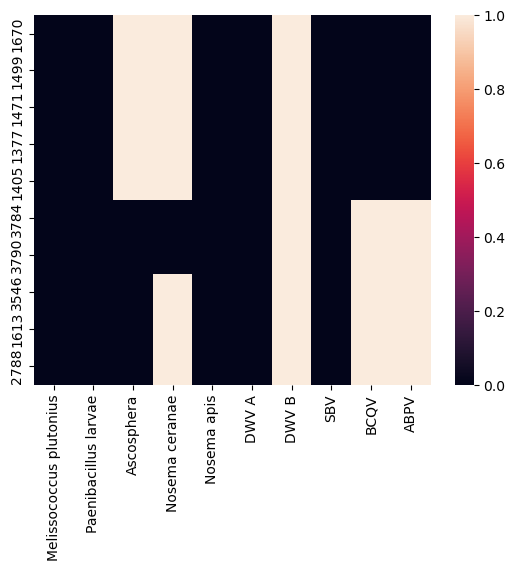

In [47]:
sns.heatmap(zoom_df)

In [70]:
df_all[original_index:original_index+1]

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
3784,36,R20,C03,2022-07-19 00:00:00,V3,flat,-,flat,-,25.31,-,25,-,34.69,-,33.08,-,13.09,11.6,+,31.02,NaN,-,NaN,NaN,NaN,22.555,2.135,+,28.75,NaN,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
patho_row = df_all[original_index:original_index+1]

In [95]:
'V1'.lower()

'v1'

In [96]:
coleval_df[
    (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
    (coleval_df['year'] == patho_row.iloc[0, 3].year) &
    (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
    (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
]

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
792,v3R20C032022,R20,2022,C03,2021.0,2022-07-19,v3,am,Jud Marcel,D,D,0.0,colonie,375.0,0.0,9562.5,425.0,17000.0,300.0,34.02,255.0,28.917


In [78]:
patho_row.loc[:, 'Rucher']

3784    R20
Name: Rucher, dtype: object

In [97]:
def get_coleval_row(coleval_df, patho_row):
    return coleval_df[
        (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
        (coleval_df['year'] == patho_row.iloc[0, 3].year) &
        (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
        (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
        ]

In [118]:
original_index = 1290 # bacteria
# original_index = 3496
# original_index = 1411
# original_index = 3784

In [115]:
patho_row  = df_all[original_index:original_index+1]

In [116]:
patho_row

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
1290,503,R16,C09,2019-04-23 00:00:00,V1,27.475,+,18.99,+,27.495,-,25.27,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.36,NaN,-,flat,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN


In [117]:
coleval_df[
        (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
        (coleval_df['year'] == 2020) &
        (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
        (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
        ]

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
158,v1R16C092020,R16,2020,C09,2018.0,2020-04-15,v1,pm,cedric,D,NaN,0.0,colonie,345.0,0.0,8797.5,200.0,8000.0,185.0,20.979,50.0,5.67


In [119]:
get_coleval_row(coleval_df, df_all[original_index:original_index+1])

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
158,v1R16C092019,R16,2019,C09,2018.0,2019-04-23,v1,pm,cedric,D,NaN,0.0,colonie,190.0,0.0,4845.0,220.0,8800.0,95.0,10.773,100.0,11.34


In [ ]:
patho_row 

TO DO:
-  validate I understood correctly these tables...
- 
-  understand clusters
-  think abundances (how treat absences, mask value when absent)


# Sample selections

In [69]:
mp_df = df_all[~df_all['Melissococcus plutonius Ct value'].isin({'flat', 'flat !', np.nan, 'X'})]

mp_df['Melissococcus plutonius Ct value'] = np.array(mp_df['Melissococcus plutonius Ct value'].to_numpy(), dtype=float)

/tmp/ipykernel_172259/3498131122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_df['Melissococcus plutonius Ct value'] = np.array(mp_df['Melissococcus plutonius Ct value'].to_numpy(), dtype=float)


<Axes: xlabel='Melissococcus plutonius Ct value', ylabel='Count'>

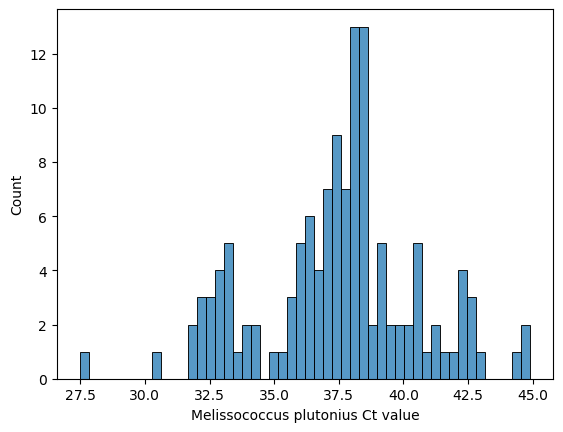

In [70]:
sns.histplot(mp_df['Melissococcus plutonius Ct value'], bins=50)

In [91]:
mp_high = mp_df[mp_df['Melissococcus plutonius Ct value'] < 30].index.to_numpy()
mp_med = mp_df[(mp_df['Melissococcus plutonius Ct value'] > 30) & (mp_df['Melissococcus plutonius Ct value'] < 33)].index.to_numpy()
mp_low = mp_df[(mp_df['Melissococcus plutonius Ct value'] > 35) & (mp_df['Melissococcus plutonius Ct value'] < 38)].index.to_numpy()

df_all.iloc[mp_high, :]

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
1290,503,R16,C09,2019-04-23 00:00:00,V1,27.475,+,18.99,+,27.495,-,25.27,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.36,NaN,-,flat,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN


In [123]:
dwvb_df = df_all[~df_all['DWV B Ct value'].isin({'flat', 'flat ', 'flat !', np.nan, 'X'})]

dwvb_df['DWV B Ct value'] = np.array(dwvb_df['DWV B Ct value'].to_numpy(), dtype=float)
dwvb_df['DWV B delta Ct'] = np.array(dwvb_df['DWV B delta Ct'].to_numpy(), dtype=float)

/tmp/ipykernel_172259/776051710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwvb_df['DWV B Ct value'] = np.array(dwvb_df['DWV B Ct value'].to_numpy(), dtype=float)
/tmp/ipykernel_172259/776051710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwvb_df['DWV B delta Ct'] = np.array(dwvb_df['DWV B delta Ct'].to_numpy(), dtype=float)


<Axes: xlabel='DWV B Ct value', ylabel='Count'>

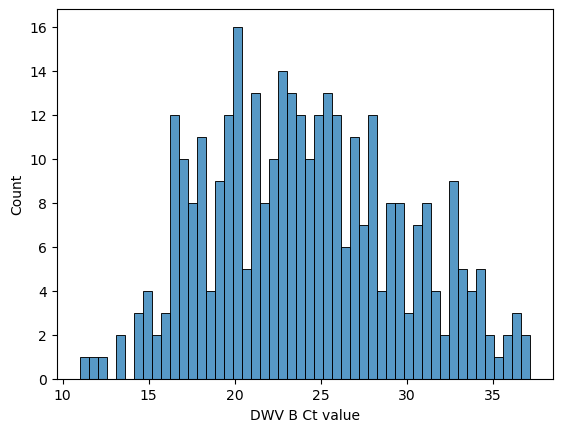

In [130]:
sns.histplot(dwvb_df['DWV B Ct value'], bins=50)

<Axes: xlabel='DWV B Ct value', ylabel='DWV B delta Ct'>

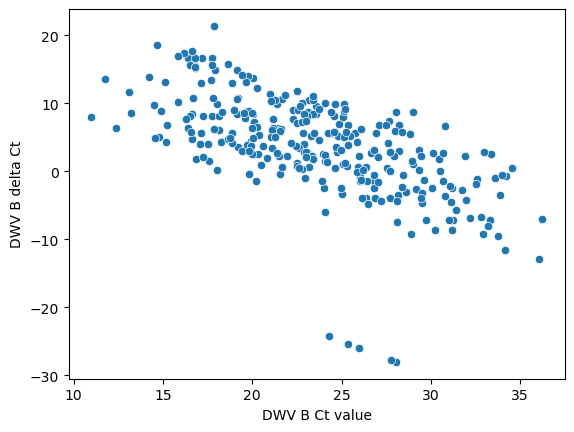

In [133]:
sns.scatterplot(data=dwvb_df, x='DWV B Ct value', y='DWV B delta Ct')

<Axes: xlabel='DWV B delta Ct', ylabel='Count'>

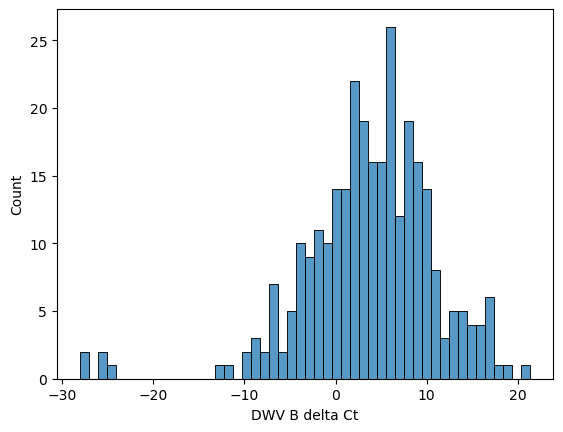

In [129]:
sns.histplot(dwvb_df['DWV B delta Ct'], bins=50)

In [141]:
from itertools import product

In [134]:
dwvb_low = dwvb_df[(dwvb_df['DWV B delta Ct'] > -15) & (dwvb_df['DWV B delta Ct'] < -5)].index.to_numpy()
dwvb_med = dwvb_df[(dwvb_df['DWV B delta Ct'] > 5) & (dwvb_df['DWV B delta Ct'] < 10)].index.to_numpy()
dwvb_high = dwvb_df[(dwvb_df['DWV B delta Ct'] > 15) & (dwvb_df['DWV B delta Ct'] < 25)].index.to_numpy()

In [143]:
for a, b in product([dwvb_low, dwvb_med, dwvb_high], [mp_low, mp_med, mp_high]):
    print(set(a).intersection(b))

set()
set()
set()
{2753, 2777, 3981, 3404}
set()
set()
set()
set()
set()


In [147]:
# pick med here
set(dwvb_med).intersection(mp_low)

{2753, 2777, 3404, 3981}

In [153]:
dwvba = df_all[(df_all['DWV B Detected'] == '+') & (df_all['DWV A Detected'] == '+')].index.to_numpy()

In [160]:
np.intersect1d()

array([ 886, 1405, 1621, 1627, 1649, 1694, 1745, 2641, 2689, 2715, 2729,
       2767, 3828, 3839, 3846, 3855, 3927, 4014])

In [172]:
#  both deformed wings variants
set(list(dwvb_high)).intersection(dwvba)

{1785}

1785: high DWV B & presence of DWV A
[2753, 2777, 3981, 3404] : med dwvb and low MP


In [195]:
cand_samples = [1785] + [2753, 2777, 3981, 3404] + list(dwvb_low) + list(mp_med) + list(mp_high) + [3496]

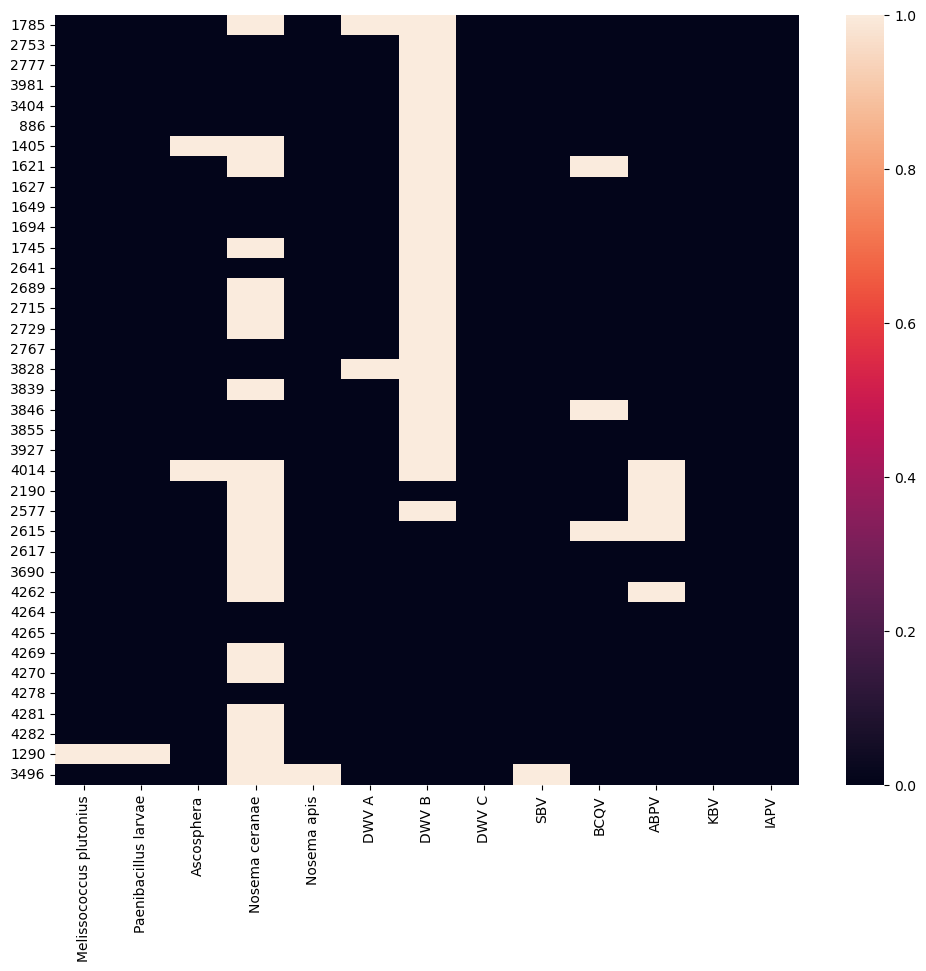

In [196]:
plt.figure(figsize=(12, 10))
cg = sns.heatmap(df_prev.iloc[cand_samples, :])
plt.show()

In [171]:
dwvb_low

array([ 886, 1405, 1621, 1627, 1649, 1694, 1745, 2641, 2689, 2715, 2729,
       2767, 3828, 3839, 3846, 3855, 3927, 4014])

In [155]:
np.array([dwvb_low, dwvb_med, dwvb_high]).flatten()



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [150]:
df_all.columns

Index(['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite',
       'Melissococcus plutonius Ct value', 'Melissococcus plutonius Detected',
       'Paenibacillus larvae Ct value', 'Paenibacillus larvae Detected',
       'Ascosphera Ct value', 'Ascosphera Detected', 'Nosema ceranae Ct value',
       'Nosema ceranae Detected', 'Nosema apis Ct value',
       'Nosema apis Detected', 'DWV A Ct value', 'DWV A Detected',
       'DWV B Ct value', 'DWV B delta Ct', 'DWV B Detected', 'DWV C Ct value',
       'DWV C delta Ct', 'DWV C Detected', 'SBV Ct value', 'SBV delta Ct',
       'SBV Detected', 'BCQV Ct value', 'BCQV delta Ct', 'BCQV Detected',
       'ABPV Ct value', 'ABPV delta Ct', 'ABPV Detected', 'KBV Ct value',
       'KBV delta Ct', 'KBV Detected', 'IAPV Ct value', 'IAPV delta Ct',
       'IAPV Detected', 'DWV A delta Ct'],
      dtype='object')

In [ ]:
sns.histplot(dwvb_df['DWV B Ct value'], bins=50)